<a href="https://colab.research.google.com/github/justinballas/Articles/blob/main/BICFR_Subaccount_Rankings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xlsxwriter

     |████████████████████████████████| 153kB 4.0MB/s 


In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter
%matplotlib inline

     Carrier  ... Prospectus Net Expense Ratio
0    Lincoln  ...                         0.99
3    Lincoln  ...                         0.82
4    Lincoln  ...                         0.72
5    Lincoln  ...                         0.85
6    Lincoln  ...                         0.58
..       ...  ...                          ...
152  Lincoln  ...                         0.55
153  Lincoln  ...                         0.60
154  Lincoln  ...                         0.55
155  Lincoln  ...                         0.54
156  Lincoln  ...                         1.14

[138 rows x 79 columns]
        Carrier  ... Prospectus Net Expense Ratio
0    Nationwide  ...                         0.62
2    Nationwide  ...                         0.82
3    Nationwide  ...                         0.47
4    Nationwide  ...                         0.73
5    Nationwide  ...                         0.55
..          ...  ...                          ...
154  Nationwide  ...                         0.14
155  Nation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/xlsxwriter/workbook.py:338: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


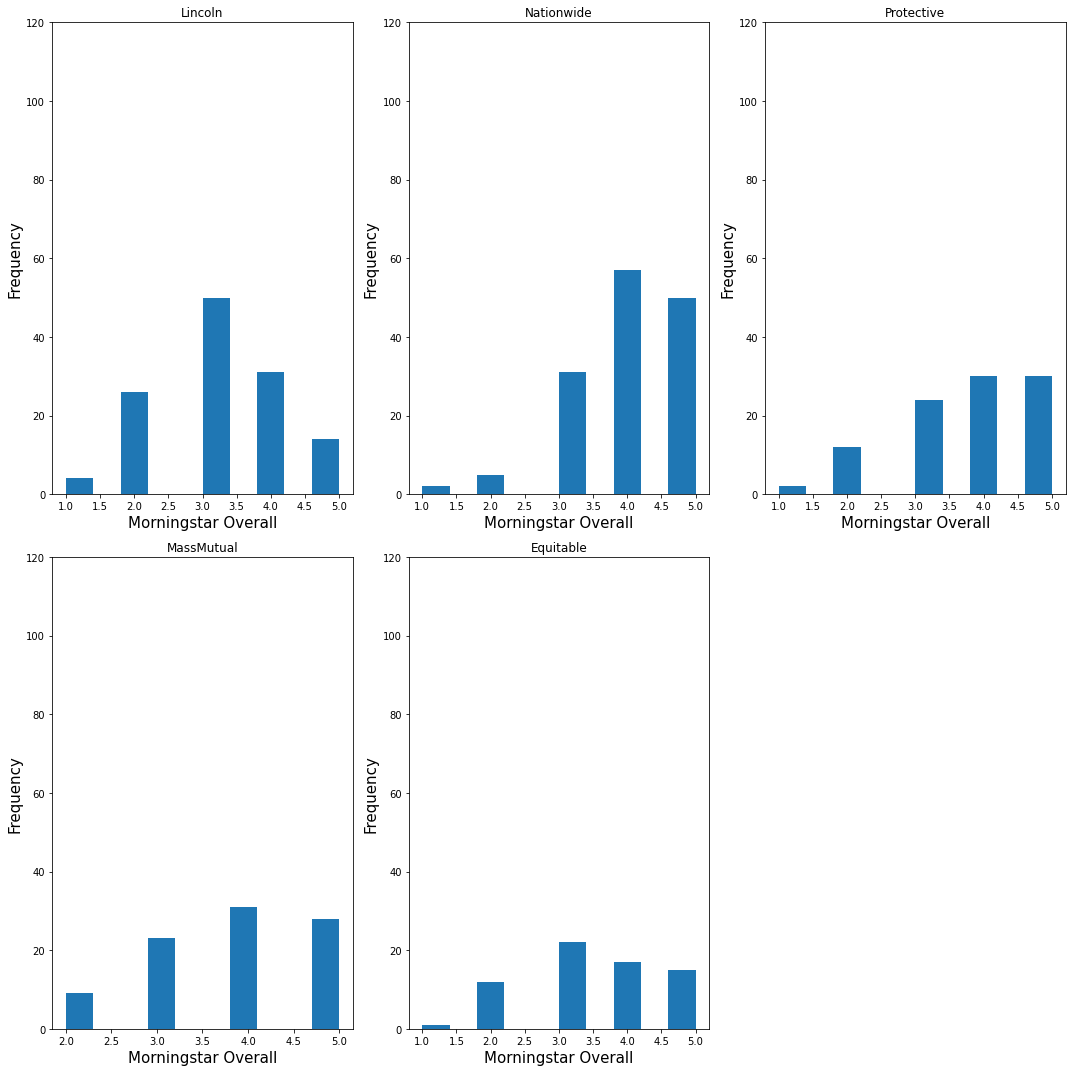

In [262]:
carriers_list = ['Lincoln', 'Nationwide', 'Protective', 'MassMutual', 'Equitable']

carrier_dfs = {}
for carrier in carriers_list:
  df = pd.read_excel('Subaccount_Rankings_data_03062021.xlsx', sheet_name=carrier)
  carrier_dfs[carrier] = df
 #skipfooter=13

for carrier, df in carrier_dfs.items():
  df.rename(columns=lambda x: x.replace('\n',''), inplace=True)

replace_list = ["US Insurance ","US Fund ", "US VUL Sub ", "US VL Sub "]

for carrier in carriers_list:
  temp_df = carrier_dfs[carrier]
  temp_df.drop(temp_df[temp_df['Closed to New Inv']=='Yes'].index, inplace=True)
  temp_df['Name'] = temp_df['Name'].str.split("-", 1).apply(lambda x: x[1])
  for phrase in replace_list:
    temp_df['Morningstar Category'] = temp_df['Morningstar Category'].str.replace(phrase, "")


mnstar_ratings = []
for carrier, df in carrier_dfs.items():
  temp_df = df
  temp_df.insert(loc=0, column='Carrier', value=carrier)
  mnstar_ratings.append(temp_df)
  print(temp_df)

ratings_df = pd.concat(mnstar_ratings)

ratings_df.drop(df[df['Closed to New Inv']=='Yes'].index, inplace=True)

agg_df_carrier = pd.pivot_table(ratings_df, index='Carrier', fill_value=np.nan)

agg_df_class = pd.pivot_table(ratings_df, index='Morningstar Category', fill_value=np.nan)

fig = plt.figure(figsize=[15, 15])



#Creating Hsitogram
for carrier in enumerate(carrier_dfs.keys()):
  temp_df = ratings_df[ratings_df['Carrier']==carrier[1]]
  temp_df = temp_df[['Morningstar Rating Overall','Carrier']]
  ax = fig.add_subplot(2, 3, carrier[0]+1)
  title = temp_df.iloc[0,1]
  plt.ylim(0,120)
  plt.xlabel('Morningstar Overall',fontsize=15)
  plt.ylabel('Frequency',fontsize=15)
  plt.title(title)
  ax.hist(temp_df['Morningstar Rating Overall'])
  plt.tight_layout()

plt.savefig('Carrier Histograms.png')


#Seperating into tables for different sheets
man_tenure = pd.merge(agg_df_carrier['Manager Tenure (Average)'], agg_df_carrier['Manager Tenure (Average)'].rank(ascending=False), how='left', left_index=True, right_index=True,suffixes=('', ' Rank'))

sharpe = pd.merge(agg_df_carrier['Sharpe Ratio 3 Yr (Mo-End) Risk Currency'], agg_df_carrier['Sharpe Ratio 3 Yr (Mo-End) Risk Currency'].rank(ascending=False), how='left', left_index=True, right_index=True,suffixes=('', ' Rank'))

exp_ratio = pd.merge(agg_df_carrier['Prospectus Net Expense Ratio'], agg_df_carrier['Prospectus Net Expense Ratio'].rank(), how='left', left_index=True, right_index=True,suffixes=('', ' Rank'))
ms_ratings_cols = ['Morningstar Rating 10 Yr', 'Morningstar Rating 5 Yr', 'Morningstar Rating 3 Yr', 'Morningstar Rating Overall']
ms_ratings =  agg_df_carrier.loc[:,ms_ratings_cols]



#--------------------------------------
for col in ms_ratings_cols:
  ms_ratings["{} Rank".format(col)] = ms_ratings[col].rank(ascending=False)

#--------------------------------------
rank_cat_cols = ['Total Ret % Rank Cat 1 Yr (Mo-End)', 'Total Ret % Rank Cat 3 Yr (Mo-End)', 'Total Ret % Rank Cat 5 Yr (Mo-End)', 'Total Ret % Rank Cat 10 Yr (Mo-End)']
rank_cat = agg_df_carrier.loc[:, rank_cat_cols]

for col in rank_cat_cols:
  rank_cat["{} Rank".format(col)] = rank_cat[col].rank()

#--------------------------------------
total_ret_cols = ['Total Ret 1 Yr (Mo-End) Base Currency', 'Total Ret Annlzd 3 Yr (Mo-End) Base Currency', 'Total Ret Annlzd 5 Yr (Mo-End) Base Currency', 'Total Ret Annlzd 10 Yr (Mo-End) Base Currency']
total_ret = agg_df_carrier.loc[:, total_ret_cols]

for col in total_ret_cols:
  total_ret["{} Rank".format(col)] = total_ret[col].rank(ascending=False)


#Best in class fund selection
asset_classes = ratings_df['Morningstar Category'].unique()

ratings_df['sum_ratings'] = ratings_df['Morningstar Rating 10 Yr'] + ratings_df['Morningstar Rating 5 Yr'] + ratings_df['Morningstar Rating 3 Yr'] + ratings_df['Morningstar Rating Overall']

ratings_df['avg_rankings'] = (ratings_df['Total Ret % Rank Cat 1 Yr (Mo-End)'] + ratings_df['Total Ret % Rank Cat 3 Yr (Mo-End)'] + ratings_df['Total Ret % Rank Cat 5 Yr (Mo-End)'] + ratings_df['Total Ret % Rank Cat 10 Yr (Mo-End)'])/4

ratings_df['total_score'] = ratings_df['sum_ratings'] + ratings_df['avg_rankings'].apply(lambda x: 1-(x/100))

bicf_list = []
for carrier in carriers_list:
  temp_df = ratings_df[ratings_df['Carrier']==carrier]
  for asset_class in asset_classes:
    class_df = temp_df[temp_df['Morningstar Category']==asset_class]
    class_df['BICF'] = ['yes' if i == class_df['total_score'].max() else 'no' for i in class_df['total_score']]
    bicf_list.append(class_df)
    
ratings_df = pd.concat(bicf_list)

man_tenure = man_tenure.transpose()
ms_ratings = ms_ratings.transpose()
sharpe = sharpe.transpose()
exp_ratio = exp_ratio.transpose()
rank_cat = rank_cat.transpose()
total_ret = total_ret.transpose()


#writing to excel
xlwriter = pd.ExcelWriter('BICFR Subaccount Rankings.xlsx', engine='xlsxwriter')

man_tenure.to_excel(xlwriter, sheet_name='Manager Tenure')
ms_ratings.to_excel(xlwriter, sheet_name='Ratings')
sharpe.to_excel(xlwriter, sheet_name='Sharpe')
exp_ratio.to_excel(xlwriter, sheet_name='Expense Ratio')
rank_cat.to_excel(xlwriter, sheet_name='Return Rankings')
total_ret.to_excel(xlwriter, sheet_name='Total Return')

agg_df_class.to_excel(xlwriter, sheet_name='Asset Class Breakdown')

bicf_df = ratings_df[ratings_df['BICF']=='yes']
bicf_df.set_index(['Carrier','Morningstar Category'], inplace=True)
bicf_df.to_excel(xlwriter, sheet_name='BICFR')

ratings_df.set_index(['Carrier', 'Name'], inplace=True)
ratings_df.to_excel(xlwriter, sheet_name='All Data')

empty_sheet = pd.DataFrame()
empty_sheet.to_excel(xlwriter, sheet_name='Histogram')
worksheet=xlwriter.sheets['Histogram']
worksheet.insert_image('B2','Carrier Histograms.png')

list(carrier_dfs.values())[0].to_excel(xlwriter, sheet_name='{}'.format(carriers_list[0]))
list(carrier_dfs.values())[1].to_excel(xlwriter, sheet_name='{}'.format(carriers_list[1]))
list(carrier_dfs.values())[2].to_excel(xlwriter, sheet_name='{}'.format(carriers_list[2]))
list(carrier_dfs.values())[3].to_excel(xlwriter, sheet_name='{}'.format(carriers_list[3]))
list(carrier_dfs.values())[3].to_excel(xlwriter, sheet_name='{}'.format(carriers_list[4]))

xlwriter.save()

xlwriter.close()

In [261]:
ratings_df['Morningstar Category'].unique()

array(['Allocation--30% to 50% Equity', 'Intermediate Core-Plus Bond',
       'Large Value', 'Small Blend', 'Multistrategy',
       'Global Real Estate', 'Large Blend', 'World Small/Mid Stock',
       'Diversified Emerging Mkts', 'World Allocation', 'Mid-Cap Blend',
       'Small Growth', 'Allocation--85%+ Equity',
       'Allocation--70% to 85% Equity', 'Mid-Cap Value', 'Large Growth',
       'Allocation--15% to 30% Equity', 'Intermediate Core Bond',
       'Foreign Large Blend', 'World Large-Stock Growth',
       'Mid-Cap Growth', 'Foreign Large Growth', 'Technology',
       'Utilities', 'Allocation--50% to 70% Equity',
       'Inflation-Protected Bond', 'Ultrashort Bond', 'Small Value',
       'High Yield Bond', 'Commodities Broad Basket',
       'Nontraditional Bond', 'Natural Resources', 'Multisector Bond',
       'Money Market - Taxable', 'World Large-Stock Blend',
       'Convertibles', 'Equity Energy', 'Event Driven', 'Health'],
      dtype=object)

In [ ]:
# for carrier, df in carrier_dfs.items():
#   df.rename(columns=lambda x: x.replace('\n',''), inplace=True)

In [248]:
df = carrier_dfs['Lincoln']

In [249]:
df

,Carrier,Name,Morningstar Category,Advisor,Subadvisor,Total Ret 1 Yr (Mo-End) Base Currency,Total Ret Annlzd 3 Yr (Mo-End) Base Currency,Total Ret Annlzd 5 Yr (Mo-End) Base Currency,Total Ret Annlzd 10 Yr (Mo-End) Base Currency,Morningstar Rating Overall,Morningstar Rating 3 Yr,Morningstar Rating 5 Yr,Morningstar Rating 10 Yr,Total Ret % Rank Cat 1 Yr (Mo-End),Total Ret % Rank Cat 3 Yr (Mo-End),Total Ret % Rank Cat 5 Yr (Mo-End),Total Ret % Rank Cat 10 Yr (Mo-End),Manager Tenure (Average),Total Net Expense,Sharpe Ratio 3 Yr (Mo-End) Risk Currency,Std Dev 3 Yr (Mo-End) Risk Currency,Yield to Maturity,Modified Duration,Ticker,Underlying Fund CUSIP,Closed to New Inv,Total Ret YTD (Daily) Base Currency,Total Ret YTD (Mo-End) Base Currency,Total Ret Inception (Mo-End) Base Currency,Inception Date,Sustainable Investment - ESG Fund Overall 2018-03,Sustainable Investment - ESG Fund Overall 2018-04,Sustainable Investment - ESG Fund Overall 2018-05,Sustainable Investment - ESG Fund Overall 2018-06,Sustainable Investment - ESG Fund Overall 2018-07,Sustainable Investment - ESG Fund Overall 2018-08,Sustainable Investment - ESG Fund Overall 2018-09,Sustainable Investment - ESG Fund Overall 2018-10,Sustainable Investment - ESG Fund Overall 2018-11,Sustainable Investment - ESG Fund Overall 2018-12,Sustainable Investment - ESG Fund Overall 2019-01,Sustainable Investment - ESG Fund Overall 2019-02,Sustainable Investment - ESG Fund Overall 2019-03,Sustainable Investment - ESG Fund Overall 2019-04,Sustainable Investment - ESG Fund Overall 2019-05,Sustainable Investment - ESG Fund Overall 2019-06,Sustainable Investment - ESG Fund Overall 2019-07,Sustainable Investment - ESG Fund Overall 2019-08,Sustainable Investment - ESG Fund Overall 2019-09,Sustainable Investment - ESG Fund Overall 2019-10,Sustainable Investment - ESG Fund Overall 2019-11,Sustainable Investment - ESG Fund Overall 2019-12,Sustainable Investment - ESG Fund Overall 2020-01,Sustainable Investment - ESG Fund Overall 2020-02,Sustainable Investment - ESG Fund Overall 2020-03,Sustainable Investment - ESG Fund Overall 2020-04,Sustainable Investment - ESG Fund Overall 2020-05,Sustainable Investment - ESG Fund Overall 2020-06,Sustainable Investment - ESG Fund Overall 2020-07,Sustainable Investment - ESG Fund Overall 2020-08,Sustainable Investment - ESG Fund Overall 2020-09,Sustainable Investment - ESG Fund Overall 2020-10,Sustainable Investment - ESG Fund Overall 2020-11,Sustainable Investment - ESG Fund Overall 2020-12,Sustainable Investment - ESG Fund Overall 2021-01,Sustainable Investment - ESG Fund Overall 2021-02,Portfolio Sustainability Score,Morningstar Sustainability Rating™,Portfolio Environmental Risk Score,Portfolio Social Risk Score,Portfolio Governance Risk Score,Percent of AUM Covered - ESG,Percent of AUM Covered - Controversy,Historical Sustainability Score,Annual Report Net Expense Ratio Year2018,Annual Report Net Expense Ratio Year2019,Annual Report Net Expense Ratio Year2020,Annual Report Net Expense Ratio,Prospectus Net Expense Ratio
0,Lincoln,LNL CC VUL-AB VPS Global Thematic Growth A,World Large-Stock Growth,AllianceBernstein L.P.,NaN,47.34,20.37,19.61,10.49,3.0,4.0,4.0,2.0,20.0,19.0,15.0,69.0,8.08,0.99,1.07,17.65,NaN,NaN,NaN,18792770,NaN,7.83,8.21,7.59,2008-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,20.94,Above Average,3.13,8.42,6.46,94.48,95.19,20.87,0.99,0.99,0.94,0.94,0.99
3,Lincoln,LNL CC VUL-AB VPS Small/Mid Cap Value A,Small Value,AllianceBernstein L.P.,NaN,78.72,10.39,12.76,11.07,4.0,3.0,3.0,4.0,51.0,43.0,42.0,23.0,8.46,0.82,0.46,26.96,NaN,NaN,NaN,18792531,NaN,31.86,30.99,10.76,2008-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,24.93,Average,3.24,5.71,4.69,99.23,99.23,25.17,0.81,0.82,0.83,0.83,0.82
4,Lincoln,LNL CC VUL-American Century VP Inflation Prot II,Inflation-Protected Bond,American Century Inves

In [250]:
df['Name'] = df['Name'].str.split("-").apply(lambda x: x[1])

In [251]:
df['Name']

0            AB VPS Global Thematic Growth A
3               AB VPS Small/Mid Cap Value A
4      American Century VP Inflation Prot II
5        American Century VP Mid Cap Value I
6                 American Funds IS® Amer Hi
                       ...                  
152                     TOPS® Balanced ETF 2
153                 TOPS® Conservative ETF 2
154                       TOPS® Growth ETF 2
155              TOPS® Moderate Growth ETF 2
156                 Wells Fargo VT Discovery
Name: Name, Length: 138, dtype: object